## Text classification with an RNN
https://www.tensorflow.org/alpha/tutorials/text/text_classification_rnn

Here we will train an RNN to classify the IMDB large movie review dataset.

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

def plotCurves(history, name):
    """Helper function for plotting learning curves."""
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.xlabel('Epochs')
    plt.ylabel(name.title())
    plt.legend([name, 'val_'+name])
    plt.show()

### Input pipeline
Let's download the data.

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k',
                          with_info=True,
                          as_supervised=True)
trainSet, testSet = dataset['train'], dataset['test']

W0605 13:38:31.208915 140245246871360 deprecation.py:323] From /home/yeon/appl/anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow_datasets/core/file_format_adapter.py:247: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/yeon/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


The dataset comes with an inbuilt **subword tokenizer**:

In [15]:
tokenizer = info.features['text'].encoder
print('Vocabulary size:', tokenizer.vocab_size)

Vocabulary size: 8185


`tokenizer` can encode a sentence or decode a tokenized sequence:

In [16]:
sampleString = "Summer is so hot."

tokens = tokenizer.encode(sampleString)
decodedString = tokenizer.decode(tokens)

print("Tokenized string:", tokens)
print("Decoded string:", decodedString)
assert decodedString == sampleString

Tokenized string: [6873, 3629, 9, 55, 2613, 7975]
Decoded string: Summer is so hot.


`tokenizer` encodes a string by breaking it into subwords if the word is not in the dictionary:

In [17]:
for token in tokens:
    print(f"{token} ----> {tokenizer.decode([token])}")

6873 ----> Sum
3629 ----> mer 
9 ----> is 
55 ----> so 
2613 ----> hot
7975 ----> .


Notice how "Summer" has been broken.

We batch the data strings with shuffling and padding and finish processing the input.

In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

trainSet = trainSet.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,
                                                      trainSet.output_shapes)
testSet = testSet.padded_batch(BATCH_SIZE, testSet.output_shapes)

### Model
In this example, we'll use a bidirectional RNN via `tf.keras`'s `Bidirectional` wrapper to help the model learn long-range dependencies.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, 'relu'),
    tf.keras.layers.Dense(1, 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


### Training

In [22]:
history = model.fit(trainSet,
                    epochs=10,
                    validation_data=testSet)

Epoch 1/10
391/391 [==============================] - 674s 2s/step - loss: 0.5462 - accuracy: 0.7182 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 690s 2s/step - loss: 0.3744 - accuracy: 0.8403 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 3/10
391/391 [==============================] - 674s 2s/step - loss: 0.4980 - accuracy: 0.7551 - val_loss: 1.6674 - val_accuracy: 0.5006
Epoch 4/10
391/391 [==============================] - 691s 2s/step - loss: 0.6216 - accuracy: 0.6573 - val_loss: 0.5897 - val_accuracy: 0.7122
Epoch 5/10
391/391 [==============================] - 713s 2s/step - loss: 0.4116 - accuracy: 0.8236 - val_loss: 0.4699 - val_accuracy: 0.7971
Epoch 6/10
391/391 [==============================] - 683s 2s/step - loss: 0.4927 - accuracy: 0.7666 - val_loss: 0.6911 - val_accuracy: 0.6755
Epoch 7/10
391/391 [==============================] - 693s 2s/step - loss: 0.4650 - accuracy: 0.7928 - val_loss: 0.7639 - val_accuracy

In [24]:
testLoss, testAcc = model.evaluate(testSetet)
print("Test loss:", testLoss)
print("Test Accuracy:", testAcc)

    391/Unknown - 64s 162ms/step - loss: 0.3683 - accuracy: 0.8603Test loss: 0.36828002013513805
Test Accuracy: 0.86028


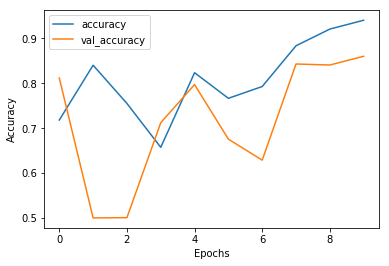

In [25]:
plotCurvesvesves(history, 'accuracy')

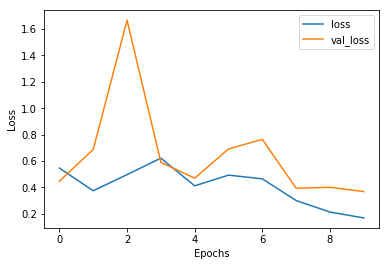

In [26]:
plotCurves(history, 'loss')

#### Problem caused by padding
The above model does not mask the padding applied to the sequences. This can lead to skewness when we test the model on unpadded sequences. Ideally the model should learn to ignore the padding. Let's see how much the prediction changes depending on the padding.

In [27]:
def predictSample(sentence: str, pad: bool):
    tokens = tokenizer.encode(sentence)
    if pad:
        tokens += [0] * (64 - len(tokens))
    return model.predict(tf.expand_dims(tokens, 0))

In [28]:
sample = ('The movie was cool. The animation and the graphics '
          'were out of this world. I would recommend this movie.')
print("Prediction w/o padding:", predictSample(sample, False))
print("Prediction with padding:", predictSample(sample, True))

Prediction w/o padding: [[0.9619552]]
Prediction with padding: [[0.9007612]]


### Model with more RNN layers
Turning on the `return_sequences` argument of `tf.keras.layers.RNN` gives the full sequence of all-timestep outputs, allowing us to add another RNN afterwards.

In [29]:
model = tf.keras.Sequentialuential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, 'relu'),
    tf.keras.layers.Dense(1, 'sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(trainSet,
                    epochs=10,
                    validation_data=testSet)

Epoch 1/10
391/391 [==============================] - 1354s 3s/step - loss: 0.6364 - accuracy: 0.6322 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 1294s 3s/step - loss: 0.5184 - accuracy: 0.7502 - val_loss: 0.5562 - val_accuracy: 0.7108
Epoch 3/10
391/391 [==============================] - 1346s 3s/step - loss: 0.5036 - accuracy: 0.7611 - val_loss: 0.5700 - val_accuracy: 0.7111
Epoch 4/10
391/391 [==============================] - 1342s 3s/step - loss: 0.4390 - accuracy: 0.8035 - val_loss: 0.5993 - val_accuracy: 0.6938
Epoch 5/10
391/391 [==============================] - 1345s 3s/step - loss: 0.4297 - accuracy: 0.8099 - val_loss: 0.6595 - val_accuracy: 0.7159
Epoch 6/10
391/391 [==============================] - 1334s 3s/step - loss: 0.3902 - accuracy: 0.8360 - val_loss: 0.5506 - val_accuracy: 0.7431
Epoch 7/10
391/391 [==============================] - 1346s 3s/step - loss: 0.3411 - accuracy: 0.8604 - val_loss: 0.4090 - val_a

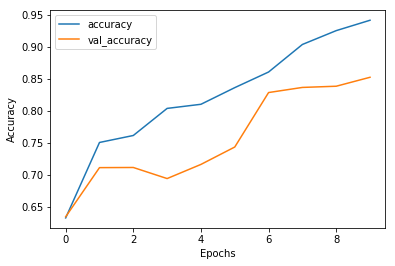

In [31]:
plotCurves(history, 'accuracy')

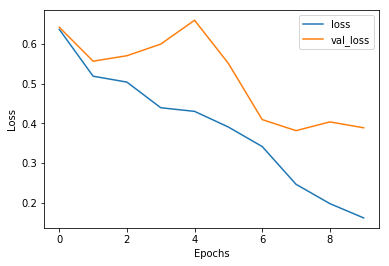

In [32]:
plotCurves(history, 'loss')

In [33]:
testLoss, testAcc = model.evaluate(testSet)
print("Test loss:", testLoss)
print("Test Accuracy:", testAcc)

    391/Unknown - 130s 331ms/step - loss: 0.3884 - accuracy: 0.8522Test loss: 0.3883729465782185
Test Accuracy: 0.85216


In [34]:
print("Prediction w/o padding:", predictSample(sample, False))
print("Prediction with padding:", predictSample(sample, True))

Prediction w/o padding: [[0.80637103]]
Prediction with padding: [[0.15160376]]


In [35]:
sample2 = ('The movie was not good. The animation and the graphics '
           'were terrible. I would not recommend this movie.')
print("Prediction w/o padding:", predictSample(sample2, False))
print("Prediction with padding:", predictSample(sample2, True))

Prediction w/o padding: [[0.01419486]]
Prediction with padding: [[0.01317374]]


We can see that the second model is more vulnerable to padding.